<a href="https://colab.research.google.com/github/chunlam-chan/quantum-coding-samples/blob/main/qaoa_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QAOA for MIMO Detection, Part 1: A PennyLane Implementation

Wireless communication systems frequently involve discrete optimization problems. In recent years, there has been growing interest in exploring quantum computing techniques to address these challenges. One such example is MIMO detection, for which a published paper [[1]](#[1]) has already proposed the use of Quantum Approximate Optimization Algorithm (QAOA).

This notebook aims to demonstrate the programming implementation of QAOA using PennyLane, a popular quantum machine learning library. By focusing on MIMO detection as an example, the goal of this notebook is to showcase how QAOA can be applied to tackle discrete optimization problems in wireless communication systems, while also providing insights into the scalability and efficiency of the optimization algorithms.

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

## Problem and formulation
A MIMO system involves transmiting a signal vector $x = [x_1, \cdots x_N]$ to $M$ antennas. The symbols $x_i$​ are discrete and belong to a finite set of constellations, representing the possible modulation schemes used in the communication system. The received signal vector $y$ at the receive antennas can be expressed as:
$$y = Hx+n$$
where $H$ is the channel matrix and $n$ denotes the additive Guassian noise vector. The objective of MIMO detection is to find the maximum likelihood solution, $x_{ML} = \min_{x \in \mathcal{X}^N} \Vert y - Hx \Vert^2$.

In this notebook, we focus on the simplest case, binary phase-shift keying (BPSK) where $\mathcal{X} = \{-1, 1\}$. Expanding the norm square and dropping the constant terms in the minimization for $x_{ML}$, we arrive at $x_{ML} = \min_{x \in \mathcal{X}^N} f(x)$ where
$$f(x) = \sum_{i<j}^{N} A_{i,j} x_i x_j + \sum_{i=1}^{N} b_i x_i.$$
Here, $A = 2H^T H$ and $b = -2H^T y$.
To facilitate the introduction of quantum algorithms, we can define $s_i = 1 - 2x_i \in \{0, 1\}$ and associate the objective function $f$ with Hamiltonian
$$H_f = \sum_{i<j}^{N} A_{i,j} \sigma_z^{(i)} \sigma_z^{(j)} + \sum_{i=1}^{N} b_i \sigma_z^{(i)}$$ such that $H_f \ket{s} = f(x(s)) \ket{s}$. In the Hamiltonian, $\sigma_z^{(i)}$ represents the Pauli Z matrix applied to the $i$-th variable. With these definitions, finding $x_{ML}$ is equivalent to finding the corresponding $s$ that minimizes the cost function $\bra{s} H_f \ket{s}$.



## From Adiabatic quantum computing to QAOA
Consider an interpolating Hamiltonian $H(t) = (1-\tau(t)) H_B + \tau(t) H_f$ such that
* $\ket{s_B}$, the ground state of $H_B$ is easy to find and prepare;
* $\tau(0) = 0$, $\tau(T)=1$.

Let $U(t_1, t_2) = e^{-i \int_{t_2}^{t_1} H(t) dt}$ (a unitary operator). The adiabatic theorem says that if $\tau(t)$ slowly changes with $t$ then the desired ML solution $\ket{s_{ML}}$ is $U(T,0) \ket{s_B}$. Essentially, the operator evolves the ground state of $H(0)$ to the ground state of $H(T)$ over time.

For significantly large $p$ and tiny $\Delta t$, Trotterization allows us to have the approximation $$U(T,0) \approx \prod_{k=1}^{p} e^{-iH(k\Delta t) \Delta t} \approx \prod_{k=1}^{p} e^{-i(1-\tau(k\Delta t))H_B \Delta t} e^{-i\tau(k\Delta t)H_f \Delta t}.$$
The last approximation is exact if $H_B$ and $H_f$ commute.

However, using a large value of $p$ could be infeasible in practice because a deep circuit is susceptible to noise and decoherence. Therefore, the proposal of QAOA is to use a variational quantum circuit with finite $p$ and replace time-dependent parameters with variables $\alpha = (\alpha_1, \dots, \alpha_p)$ and $\gamma = (\gamma_1, \dots, \gamma_p)$. This is achieved through the expression:
$$\tilde{U}(\alpha, \gamma) = \prod_{k=1}^{p} e^{-i\alpha_k H_B} e^{-i\gamma_k H_f}.$$ For a quantum circuit that can produce the state $\ket{s} = \tilde{U}(\alpha, \gamma) \ket{s_B}$ and allow us to measure the cost function $C(s) = \bra{s} H_f \ket{s}$, we can classically optimize $\alpha$ and $\gamma$. The desired circuit with the optimal parameters should yield $\ket{s}$ that maximizes $C(s)$. Hopefully, when we measure $\ket{s}$ in the computational basis, we have a high chance of observing $\ket{s_{ML}}$.

In [ ]:
try:
    import pennylane as qml
except ImportError as e:
    # Install pennylane if package is not already installed
    !pip install pennylane
    import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
from matplotlib import pyplot as plt
from scipy.optimize import minimize, LinearConstraint

np.random.seed(2023)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 45.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2


## Start coding the problem and QAOA circuit

We now proceed to instantiate the model for MIMO detection. For simplicity, we use the same example instance considered in [[1]](#[1]), which involves a $2 \times 2$ system with specified values for $H, x$ and $n$.

In [ ]:
M, N = 2, 2
H = np.array([[1.2416, -0.1741], [0.3323, -0.0804]])
x = np.array([-1, 1])
n = np.array([-1.5130, 0.3212])
y = H @ x + n

Next, we build the cost Hamiltonian $H_f$ based on the model. As in the standard QAOA, we utilize a set of Pauli X operators for the mixer Hamiltonian $H_B$.



In [ ]:
def mimo_detection(H, y):
  A = 2 * H.T @ H
  b = -2 * y.T @ H
  obs = [qml.PauliZ(i) @ qml.PauliZ(j) for i in range(N) for j in range(i)]
  coeffs = [A[i,j].numpy() for i in range(N) for j in range(i)]
  obs = obs + [qml.PauliZ(i) for i in range(N)]
  coeffs = coeffs + list(b.numpy())
  cost_h = qml.Hamiltonian(coeffs, obs)
  mixer_h = qaoa.x_mixer(wires=range(N))
  return cost_h, mixer_h

In [ ]:
cost_h, mixer_h = mimo_detection(H, y)

print(f'Cost Hamiltonian: {cost_h}')
print(f'Mixer Hamiltonian: {mixer_h}')

Cost Hamiltonian:   (-1.03448654) [Z1]
+ (7.33335874) [Z0]
+ (-0.48575896) [Z1 Z0]
Mixer Hamiltonian:   (1) [X0]
+ (1) [X1]


We can define a QAOA circuit by specifying the cost Hamiltonian, mixer Hamiltonian, and the desired depth. The following code snippet encapsulates the circuit and desired measurements within a class.

In [ ]:
class QAOA:
  def __init__(self, cost_h, mixer_h, N, depth):
    self.cost_h = cost_h
    self.mixer_h = mixer_h
    self.depth = depth
    self.wires = range(N)
    self.dev = qml.device('default.qubit', wires=self.wires)

  def _qaoa_layer(self, gamma, alpha):
    qaoa.cost_layer(gamma, self.cost_h)
    qaoa.mixer_layer(alpha, self.mixer_h)

  def _circuit(self, params):
    for w in self.wires:
      qml.Hadamard(wires=w)
    qml.layer(self._qaoa_layer, self.depth, params[0], params[1])

  def cost_function(self, params):
    @qml.qnode(self.dev)
    def qnode():
      self._circuit(params)
      return qml.expval(self.cost_h)

    return qnode()

  def probability_circuit(self, gamma, alpha):
    @qml.qnode(self.dev)
    def qnode():
      self._circuit([gamma, alpha])
      return qml.probs(wires=self.wires)

    return qnode()

  def draw_circuit(self):
    @qml.qnode(self.dev)
    def qnode(gamma, alpha):
      self._circuit([gamma, alpha])
      return qml.probs(wires=self.wires)

    return qml.draw_mpl(qnode, decimals=1, expansion_strategy='device')

  def cost_function_for_scipy(self, params_flat):
    params = params_flat.reshape((2,-1))
    return self.cost_function(params)

## Optimizing the circuit

Now we create a circuit with depth 3.

In [ ]:
depth = 3

qaoa_mimo = QAOA(cost_h, mixer_h, N, depth)

For tuning the angle parameters in the circuit, a set of classical optimizers can be found in the API reference of libraries such as [PennyLane](https://docs.pennylane.ai/en/stable/introduction/interfaces.html) and [SciPy](https://docs.scipy.org/doc/scipy/reference/optimize.html). Based on the fundamental approach, we can classify the optimizers into three main categories:
- Those based on gradients \\
    Gradient-based optimizers access the true information of gradient and use it to guide the search direction. They include the popular gradient descent method and its accelerated versions such as Adagrad, Adam and RMSprop.
- Those based on approximating gradients \\
    Approximate gradient methods, such as Simultaneous Perturbation Stochastic Approximation (SPSA), make use of noisy evaluations of the objective function to approximate the gradient, suitable for scenarios where computing gradients analytically is challenging or computationally expensive.
- Those that are gradient-free \\
    Gradient-free optimizers, like COBYLA (Constrained Optimization BY Linear Approximations) and Genetic Algorithms, do not rely on gradient information at all and are particularly useful when the objective function is non-differentiable, noisy, or subject to constraints.

While gradient descent is usually the first approach for classical optimization, we omit it here as it is often challenging to access the true gradient in a practical quantum setting. We rather test optimizers belonging to the last two categories, specifically [SPSA](https://docs.pennylane.ai/en/stable/code/api/pennylane.SPSAOptimizer.html) and [COBYLA](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-cobyla.html). Both optimizers require iterations that progressively refine the parameters. In each iteration, the cost function is evaluated at several different values of parameters, and the optimizer updates the parameters based on the evaluation results. The parameters' values at which the cost function is evaluated and the update rules differ from the optimizers.

Let's see first how QAOA with SPSA performs.

In [ ]:
spsa_max_iterations = 800
spsa_optimizer = qml.SPSAOptimizer(maxiter=spsa_max_iterations)

costs = []

params = np.random.randn(2, depth, requires_grad=True)

for i in range(spsa_max_iterations):
  params, cost = spsa_optimizer.step_and_cost(qaoa_mimo.cost_function, params)
  costs.append(cost)

probs_spsa = qaoa_mimo.probability_circuit(params[0], params[1])


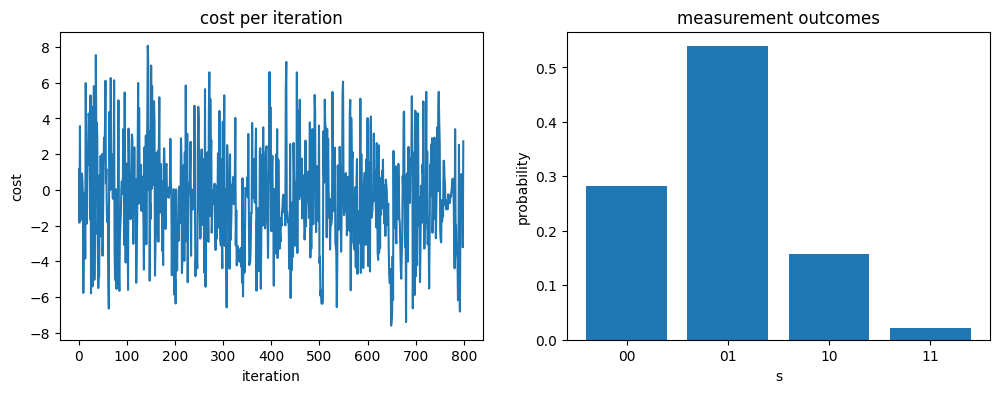

In [ ]:
wires = range(N)

fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].plot(range(len(costs)), costs)
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('cost')
axs[0].set_title('cost per iteration')

xlabel = [np.binary_repr(i, width=len(wires)) for i in range(2 ** len(wires))]
axs[1].bar(xlabel, probs_spsa)
axs[1].set_xlabel('s')
axs[1].set_ylabel('probability')
axs[1].set_title('measurement outcomes')

plt.show()

Typically, the angle paramters are optimized, and the corresponding cost function should reduce to a small value after a sufficient number of iterations. The QAOA circuit with the optimized angles is then executed and measured in the computational basis. The measurement outcome with the highest count is selected as the output solution.

From the above simulation results, it is evident that SPSA is not producing the desired outcomes. In the left figure, the cost function fluatates randomly and shows no sign of decreasing with iterations. As a result, the occurrence of measurement outcomes at the end does not peak at the true solution ($s =[1,0]$). The problem is likely that the landscape of the cost function has many local minima, which makes it challenging for the gradient to provide helpful guidance towards the optimal parameters.

Considering the limitations of SPSA, we will now switch to using COBYLA for the experiment. As the parameters $\beta, \gamma$ represent angles which effectively lie in $[0,2\pi)$, we can incorporate these linear constraints when employing COBYLA.



In [ ]:
costs = []

def callback(xk):
    costs.append(qaoa_mimo.cost_function_for_scipy(xk))

In [ ]:
params_flat = np.random.randn(2*depth, requires_grad=True)
linear_constraint = LinearConstraint(A=np.eye(2*depth), lb=np.zeros(2*depth), ub=2*np.pi*np.ones(2*depth))
out = minimize(qaoa_mimo.cost_function_for_scipy, x0=params_flat, method='COBYLA', \
               constraints=linear_constraint, callback=callback, options={'maxiter':200})

In [ ]:
params_cobyla = out['x'].reshape(2, -1)
probs_cobyla = qaoa_mimo.probability_circuit(params_cobyla[0], params_cobyla[1])

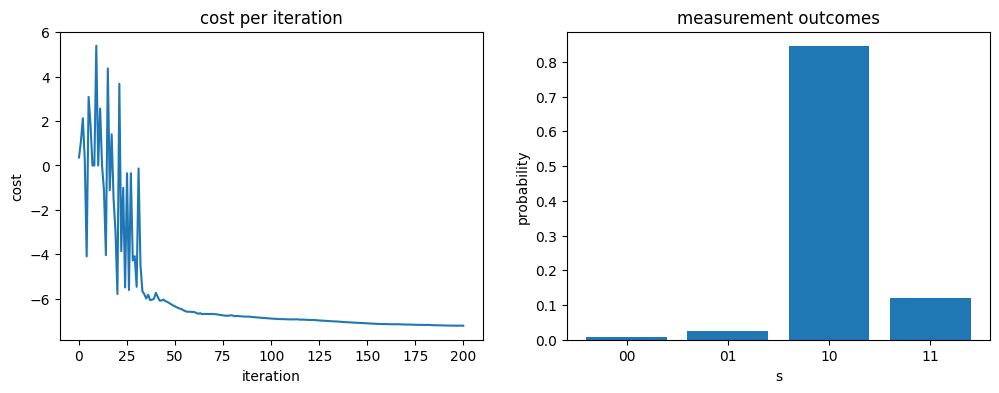

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].plot(range(len(costs)), costs)
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('cost')
axs[0].set_title('cost per iteration')

xlabel = [np.binary_repr(i, width=len(wires)) for i in range(2 ** len(wires))]
axs[1].bar(xlabel, probs_cobyla)
axs[1].set_xlabel('s')
axs[1].set_ylabel('probability')
axs[1].set_title('measurement outcomes')

plt.show()

The simulation result this time meets the expectation. COBYLA demonstrates improved convergence and accuracy for optimizing the QAOA circuit, leading to successful recovery of the true solution. We visualize the optimized circuit below.

(<Figure size 1300x300 with 1 Axes>, <Axes: >)

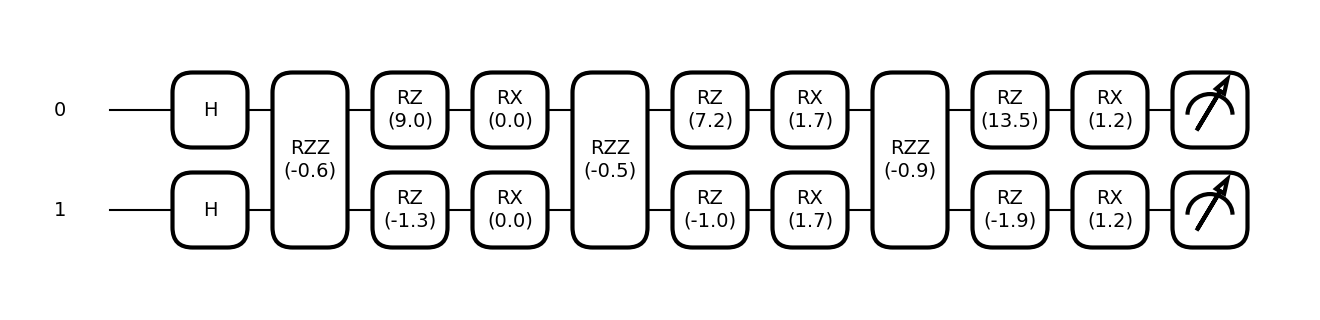

In [ ]:
drawer = qaoa_mimo.draw_circuit()
drawer(params_cobyla[0], params_cobyla[1])

## Success rate of QAOA versus the circuit depth

Having successfully recovered the true solution using COBYLA-optimized QAOA, the next possible question revolves around how the circuit depth can impact QAOA's performance. A higher depth allows the algorithm to explore a larger search space and capture more complex correlations, potentially leading to improved solution quality. To investigate this further, we will simulate QAOA for different circuit depths. In each simulation, we will repeatedly solve the same problem instance (same $H, x$ and $n$) with QAOA. However, each experiment will start with a different random initial point for COBYLA, effectively averaging the effect of initial point. The fraction of experiments in which QAOA recover the true $x$ perfectly will be recorded as the success rate.

In [ ]:
depth_list = [1, 3, 8, 13]
trials = 200
results = []

for depth in depth_list:
  print(f'At depth {depth}')
  qaoa_mimo = QAOA(cost_h, mixer_h, N, depth)

  success_cobyla = 0

  for t in range(trials):
    if t % 40 == 0:
      print(f't={t}')

    params_flat = np.random.randn(2*depth, requires_grad=True)
    linear_constraint = LinearConstraint(A=np.eye(2*depth), lb=np.zeros(2*depth), ub=2*np.pi*np.ones(2*depth))
    out = minimize(qaoa_mimo.cost_function_for_scipy, x0=params_flat, method='COBYLA', constraints=linear_constraint, options={'maxiter':100})
    params_cobyla = out['x'].reshape(2,-1)
    probs_cobyla = qaoa_mimo.probability_circuit(params_cobyla[0], params_cobyla[1])
    success_cobyla += int(np.argmax(probs_cobyla) == 2)

  results.append(success_cobyla)

At depth 1
t=0
t=40
t=80
t=120
t=160
At depth 3
t=0
t=40
t=80
t=120
t=160
At depth 8
t=0
t=40
t=80
t=120
t=160
At depth 13
t=0
t=40
t=80
t=120
t=160


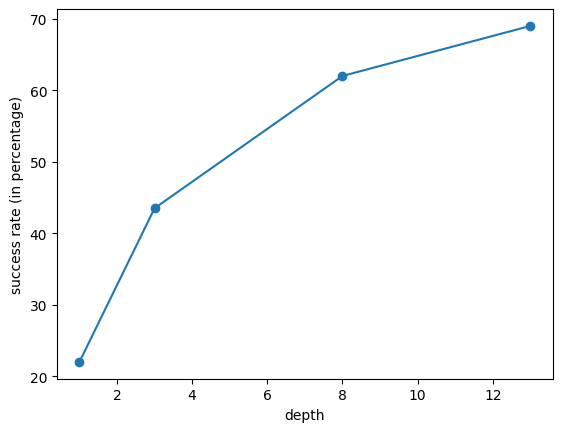

In [ ]:
plt.plot(depth_list, np.array(results) / 2, '-o')
plt.xlabel('depth')
plt.ylabel('success rate (in percentage)')

plt.show()

The above result confirms our expectation that a higher circuit depth improves the success rate with QAOA. As to determine how the depth should scale with the problem size, we refer to a study by [[2]](#[2]) on the application of QAOA to graph problems. In particular, the Sherrington–Kirkpatrick model for spin glasses is investigated in the paper and closely resemebles the problem here as both of them are represented by complete graphs. The paper suggests that a higher depth is necessary when the number of terms in the Hamiltonian relative to the number of qubits increases. Otherwise, "reachability deficits" should be expected, meaning that irrespective of the initial parameter setting, QAOA cannot prepare a quantum state such that the corresponding evaluation of the cost function approaches the optimal value.

### References
<a id="references"></a>
<a id="[1]"></a>
1. J. Cui, Y. Xiong, S.X. Ng, L. Hanzo, [*Quantum Approximate Optimization Algorithm Based Maximum Likelihood Detection*](https://arxiv.org/abs/2107.05020), IEEE Transactions on Communications, 2022

<a id="[2]"></a>
2.  V. Akshay, H. Philathong, I. Zacharov, and J. Biamonte, [*Reachability Deficits in Quantum Approximate Optimization of Graph Problems*](https://arxiv.org/abs/2007.09148), Quantum 5, 532, 2021


